# Paired integration and query-to-reference mapping

NetworkVI is a Variational Autoencoder for the paired and mosaic integration of multimodal single-cell data. Each single-cell modality is learned in individual encoders; the latent spaces are then aligned for a joint representation. In this notebook we demonstrate how to use NetworkVI for paired integration and query-to-reference mapping. We use a publically available CITE-seq dataset created by {cite}`Luecken2021`.

If you use NetworkVI, please consider citing:

Arnoldt, L., Upmeier zu Belzen, J., Herrmann, L., Nguyen, K., Theis, F.J., Wild, B. , Eils, R., "Biologically Guided Variational Inference for Interpretable Multimodal Single-Cell Integration", bioRxiv, June 2025.

In [20]:
import os
import sys

IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    !pip install networkvi

In [79]:
import numpy as np
import requests
import sys
sys.path.append("../../../src")
import networkvi
from networkvi.model import NETWORKVI
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import sklearn
from sklearn.preprocessing import normalize
import seaborn as sns
import pandas as pd

In [ ]:
%%capture
import warnings
warnings.filterwarnings("ignore")

In [32]:
%matplotlib inline

In [22]:
if not os.path.isfile(os.path.join("../../../resources/", "go-basic.obo")):
    r = requests.get("http://purl.obolibrary.org/obo/go/go-basic.obo", allow_redirects=True)
    open(os.path.join("../../../resources/", "go-basic.obo"), 'wb').write(r.content)

31220894

In [ ]:
if not os.path.isfile("../../../gene_interactions.csv"):
    import gdown
    gdown.download("https://drive.google.com/uc?export=download&id=1MwAuqw2JVl6L9xfsWGfUH7rB02LsQ_Vv", "../../../gene_interactions.csv")

## Data loading

We provide a subsetted and preprocessed version of the CITE-seq dataset for this tutorial. We filtered low qualty cells, lowly expressed features and performed subsampling to 5000 cells and feature subselection to 4000 highly variable genes. NetworkVI accepts raw counts data for all modalities. For details on the preprocessing please refer to the manuscript and the code in the [NetworkVI reproducibility repository](https://github.com/LArnoldt/networkvi_reproducibility). In the repository we also provide scripts for downloading and processing the datasets used in the manuscript. The original CITE-seq dataset contains 90261 bone marrow mononuclear cells inferred at 4 different sites with 13953 genes and 143 proteins.

In [3]:
rna_cite_path = "neurips2021_cite_bmmc_luecken2021.h5ad"

try:
    rna_cite = sc.read_h5ad(rna_cite_path)
except OSError:
    import gdown

    gdown.download("https://drive.google.com/uc?export=download&id=1A9o8wZgWS6udFMXJ-ybXre1dCcCdsKt5")
    rna_cite = sc.read_h5ad(rna_cite_path)

rna_cite

AnnData object with n_obs × n_vars = 5000 × 4000
    obs: 'cell_type', 'Site', 'DonorID'
    var: 'gene_stable_id', 'modality'
    uns: 'protein_expression'
    obsm: 'protein_expression'

## Data setup

To perform query-to-reference mapping, we select the cells inferred at one of the four different sites as the query dataset. We train NetworkVI on the rest of the dataset.

In [5]:
adata = rna_cite
query = adata[adata.obs["Site"] == "site1"].copy()
adata = adata[adata.obs["Site"] != "site1"].copy()

We register the fields and setup the anndata with a convenience function as shown below. NetworkVI requires as MultiVi to register the modality as the batch_key. Further batch information can be registered as categorical_covariate_keys.

In [6]:
NETWORKVI.setup_anndata(
    adata,
    batch_key="Site",
    protein_expression_obsm_key="protein_expression",
)

INFO     Generating sequential column names                                                                        


## Model setup and training

We demonstrate the setup and training of NetworkVI, which makes use of the Gene Ontology, as the encoder structure. Below we define a convenience function to get the latent representation and to visualize the latent space. NetworkVI requires as MultiVI the definition of the number of features per modality (n_genes, n_proteins, n_regions).

In [24]:
def get_plot_latent_representation(vae, adata):
    latent_representation = vae.get_latent_representation(modality="joint")
    adata.obsm["X_NetworkVI"] = latent_representation
    sc.pp.neighbors(adata, use_rep="X_NetworkVI")
    sc.tl.umap(adata, n_components=2)
    return adata

### NetworkVI

The mapping of the features to the gene layer and the Gene Ontology requires ENSEMBL-IDs, which we provide in ensembl_ids_genes and ensembl_ids_proteins. We also provide the Gene Ontology and a gene-to-GO mapping file in obo_file and map_ensembl_go. Please don't use the provided mapping file in production since it's an artifically subsampled version of a real mapping file. Please refer to the scripts provided in https://github.com/Larnoldt/networkvi_reproducibility or https://geneontology.org/docs/go-annotation-file-gaf-format-2.1/ to download full mapping files.

In [44]:
vae =NETWORKVI(
    adata,
    n_genes=len(adata.var[adata.var["modality"] == "Gene Expression"]),
    n_proteins=adata.obsm["protein_expression"].shape[1],
    ensembl_ids_genes=np.array(adata.var[adata.var["modality"] == "Gene Expression"]["gene_stable_id"]),
    ensembl_ids_proteins=np.array(adata.uns["protein_expression"]["var"]["gene_stable_id"]),
    gene_layer_interaction_source="../../../gene_interactions.csv",
    expression_gene_layer_type="interaction",
    protein_gene_layer_type="interaction",
    obo_file="../../../resources/go-basic.obo",
    map_ensembl_go=["../../../resources/ensembl2go.gaf"],
    layers_encoder_type="go",
    encode_covariates=True,
    deeply_inject_covariates=True,
    fully_paired=True,
    standard_gene_size=5,
    standard_go_size=2,
)

vae.train(max_epochs=10, adversarial_mixing=False, save_best=False)

INFO     Prepared gene object.                                                                                     
../../../resources/go-basic.obo: fmt(1.2) rel(2024-09-08) 44,296 Terms; optional_attrs(relationship)
../../../resources/go-basic.obo: fmt(1.2) rel(2024-09-08) 44,296 Terms; optional_attrs(relationship)
INFO     Before filtering:                                                                                         
INFO                                                                                                               
         GO object with 26554 GOTerms.                                                                             
INFO                                                                                                               
         Depth distribution (using is_a only):                                                                     
INFO                                                                                                  

/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/torch/nn/init.py:453: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


../../../resources/go-basic.obo: fmt(1.2) rel(2024-09-08) 44,296 Terms; optional_attrs(relationship)
../../../resources/go-basic.obo: fmt(1.2) rel(2024-09-08) 44,296 Terms; optional_attrs(relationship)
INFO     Before filtering:                                                                                         
INFO                                                                                                               
         GO object with 26554 GOTerms.                                                                             
INFO                                                                                                               
         Depth distribution (using is_a only):                                                                     
INFO                                                                                                               
         |----------|---|----|-----|------|------|------|------|------|------|------|------|-----|----

/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_to ...
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_to ...
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/ligh

Epoch 10/10: 100%|██████████| 10/10 [01:22<00:00,  8.36s/it, v_num=1, train_loss_step=5.01e+3, train_loss_epoch=4.74e+3]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10/10: 100%|██████████| 10/10 [01:22<00:00,  8.29s/it, v_num=1, train_loss_step=5.01e+3, train_loss_epoch=4.74e+3]


We can visualize the generated latent space:

In [45]:
adata = get_plot_latent_representation(vae, adata)

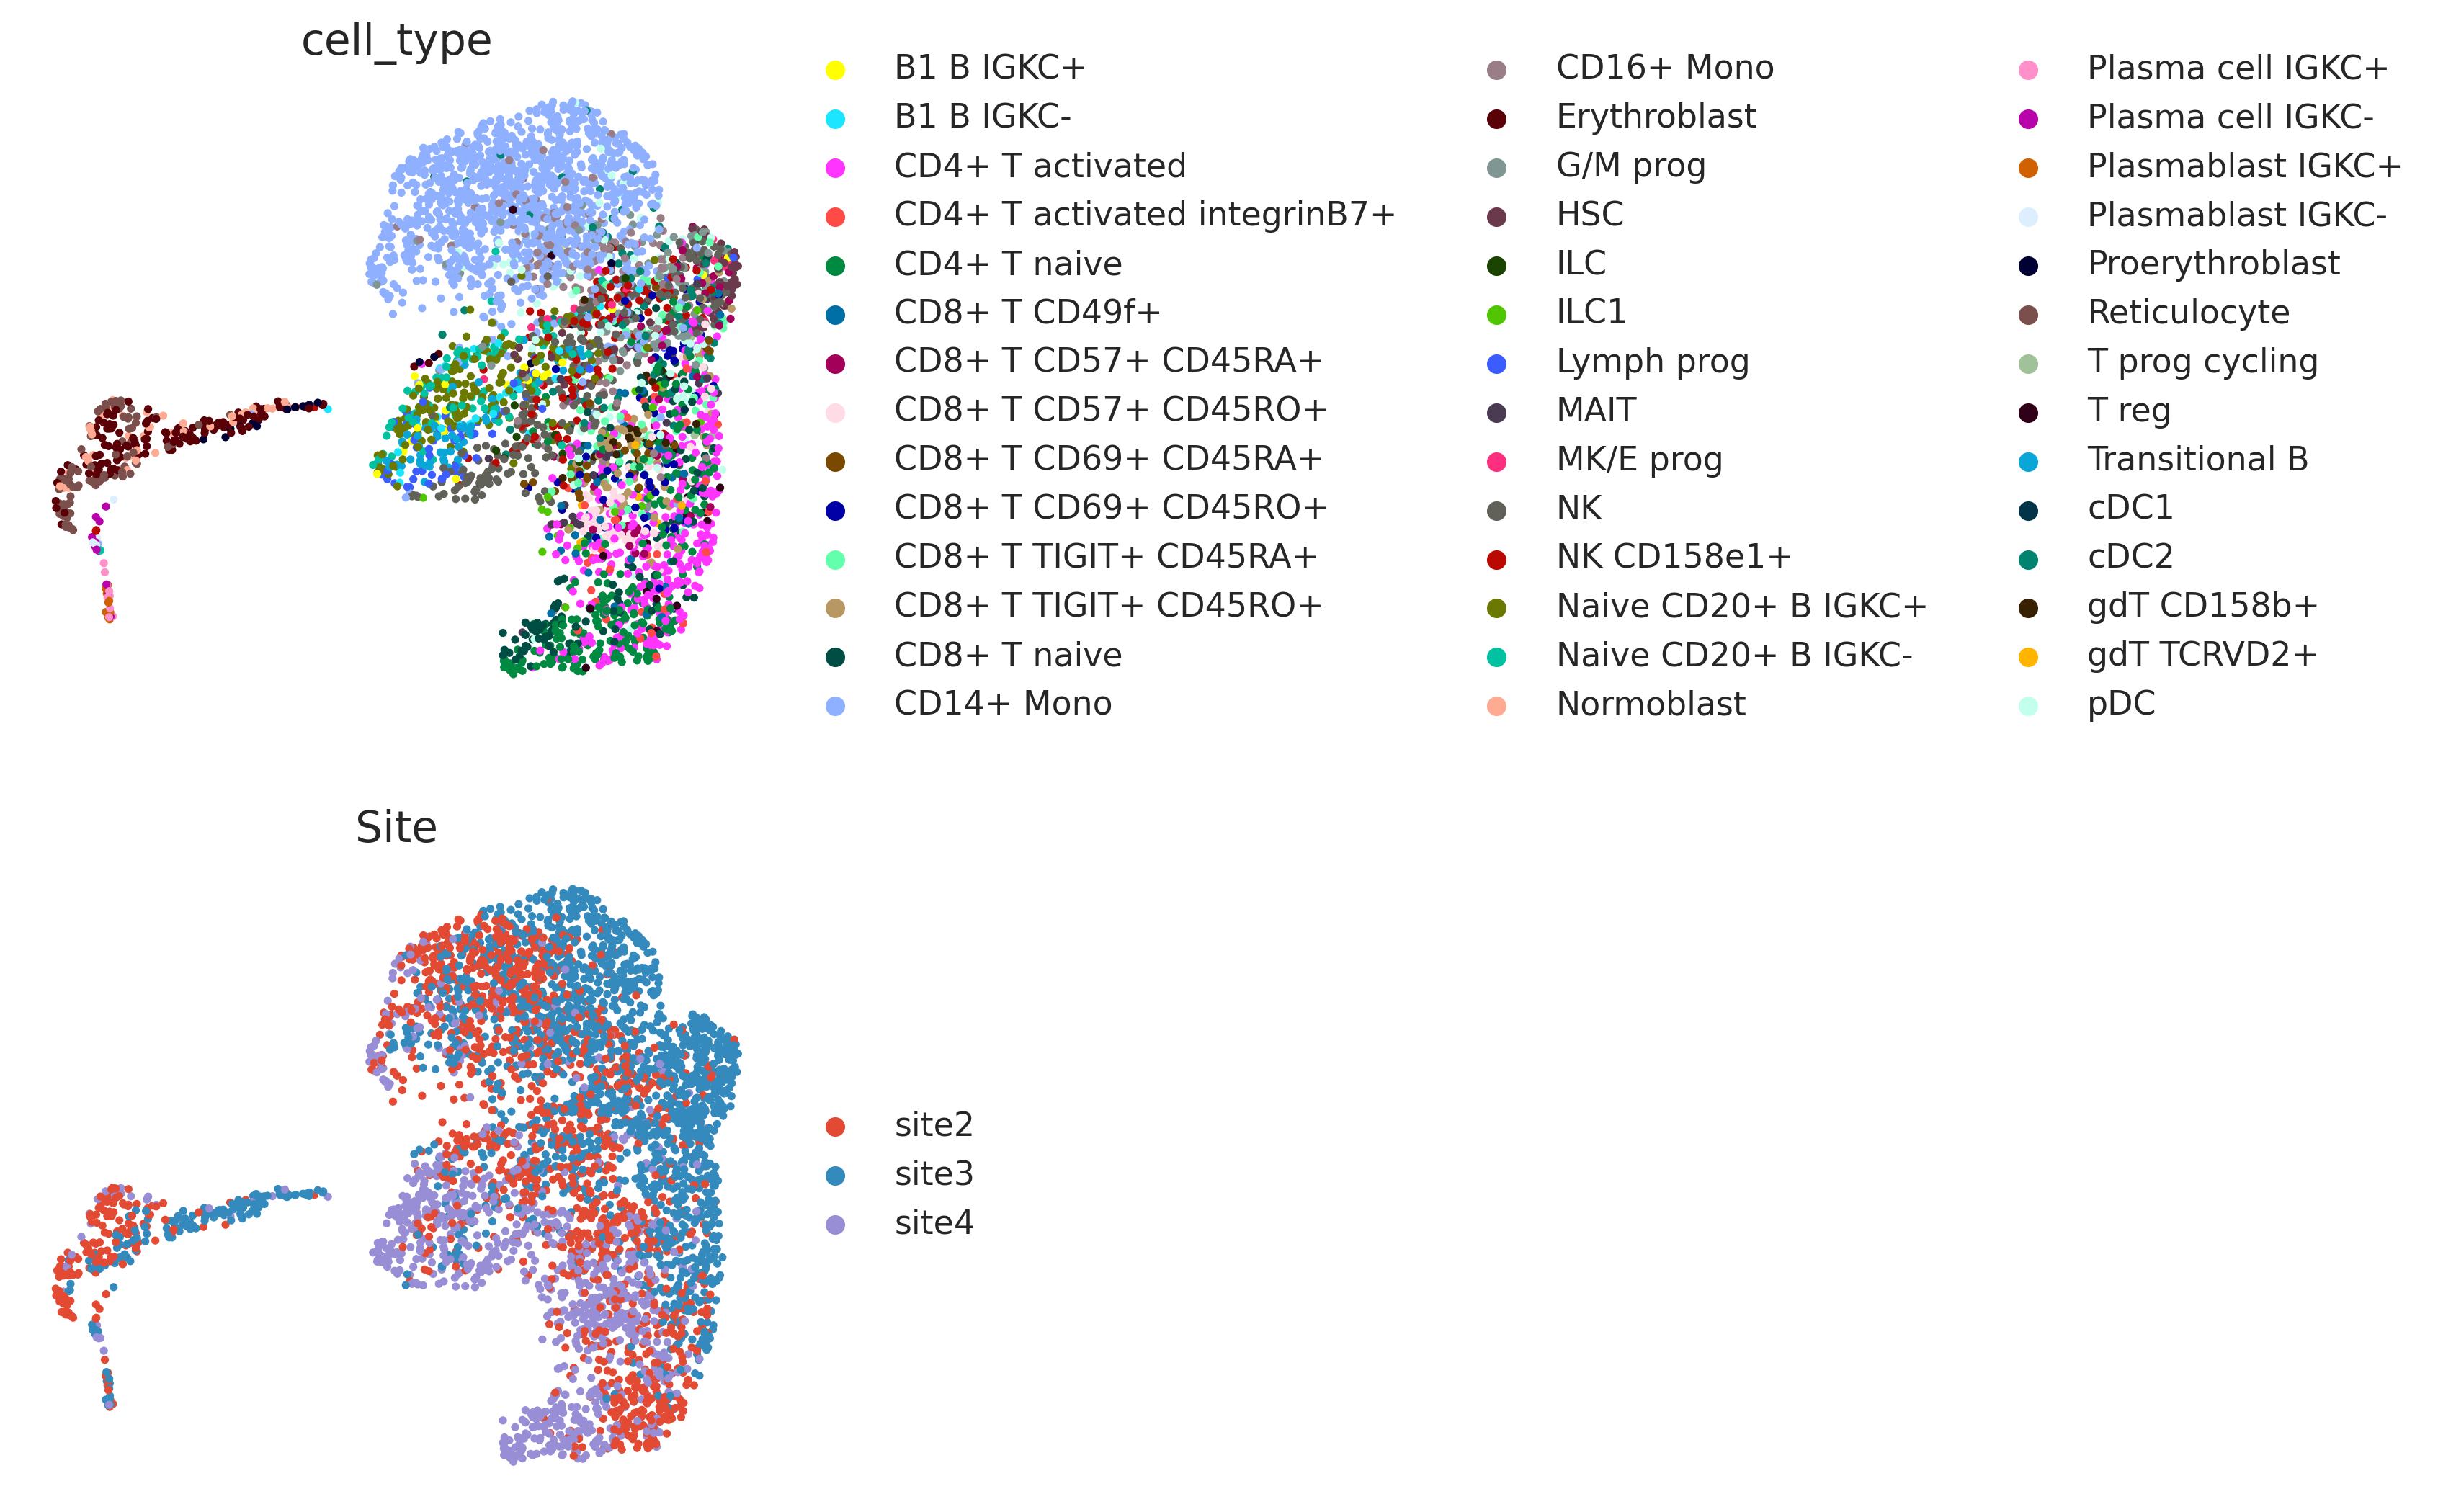

In [46]:
sc.pl.umap(adata, color=["cell_type", "Site"], frameon=False, ncols=1)

## Query-to-reference mapping

NetworkVI can be used to train a reference model for mapping new query data. NetworkVI adapts the scarches approach introduced by {cite}`Lotfollahi2022`. Here we demonstrate query-to-reference mappng for networkvi. For a query dataset, the VAE is finetuned. In short, all GO layers are frozen, while the covariate embeddings are trained. The query dataset can contain both the same modalities as the reference dataset or any subset of the modalities. NetworkVI however requires a union of features. We demonstrate how to perform label transfer using a Random Forest Classifier trained on the latent space of the reference dataset. The classifier then is used to predict labels for the query dataset. However, any classifier could be trained on the latent space.

In [47]:
latent_representation = adata.obsm["X_NetworkVI"]

In [48]:
clf = RandomForestClassifier(
    random_state=1,
    class_weight="balanced_subsample",
    verbose=1,
    n_jobs=-1,
)

In [49]:
clf.fit(adata.obsm["X_NetworkVI"], adata.obs["cell_type"])
vae.latent_space_classifer_ = clf

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished


NetworkVI loads the query data and then trains the VAE for the query dataset. Here, we freeze all parts of the network except for the covariate embeddings in the encoders and the first layer of the decoders.

In [50]:
networkvi.model.NETWORKVI.prepare_query_anndata(query, vae)

INFO     Found 100.0% reference vars in query data.                                                                


In [52]:
vae_query = NETWORKVI.load_query_data(query, vae, freeze=True, unfreeze_first_layers=True)
vae_query.train(max_epochs=10, adversarial_mixing=False, save_best=False)

INFO     Prepared gene object.                                                                                     


/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_to ...


../../../resources/go-basic.obo: fmt(1.2) rel(2024-09-08) 44,296 Terms; optional_attrs(relationship)
../../../resources/go-basic.obo: fmt(1.2) rel(2024-09-08) 44,296 Terms; optional_attrs(relationship)
INFO     Before filtering:                                                                                         
INFO                                                                                                               
         GO object with 26554 GOTerms.                                                                             
INFO                                                                                                               
         Depth distribution (using is_a only):                                                                     
INFO                                                                                                               
         |----------|---|----|-----|------|------|------|------|------|------|------|------|-----|----

/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/torch/nn/init.py:453: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


../../../resources/go-basic.obo: fmt(1.2) rel(2024-09-08) 44,296 Terms; optional_attrs(relationship)
../../../resources/go-basic.obo: fmt(1.2) rel(2024-09-08) 44,296 Terms; optional_attrs(relationship)
INFO     Before filtering:                                                                                         
INFO                                                                                                               
         GO object with 26554 GOTerms.                                                                             
INFO                                                                                                               
         Depth distribution (using is_a only):                                                                     
INFO                                                                                                               
         |----------|---|----|-----|------|------|------|------|------|------|------|------|-----|----

/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_to ...
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_to ...
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/ligh

Epoch 10/10: 100%|██████████| 10/10 [00:15<00:00,  1.57s/it, v_num=1, train_loss_step=9.78e+3, train_loss_epoch=8.32e+3]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10/10: 100%|██████████| 10/10 [00:15<00:00,  1.57s/it, v_num=1, train_loss_step=9.78e+3, train_loss_epoch=8.32e+3]


We can predict the cell types of the query dataset and visualize them accordingly in a confusion matrix:

In [90]:
predicted_labels = clf.predict(vae_query.get_latent_representation(modality="joint"))

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished


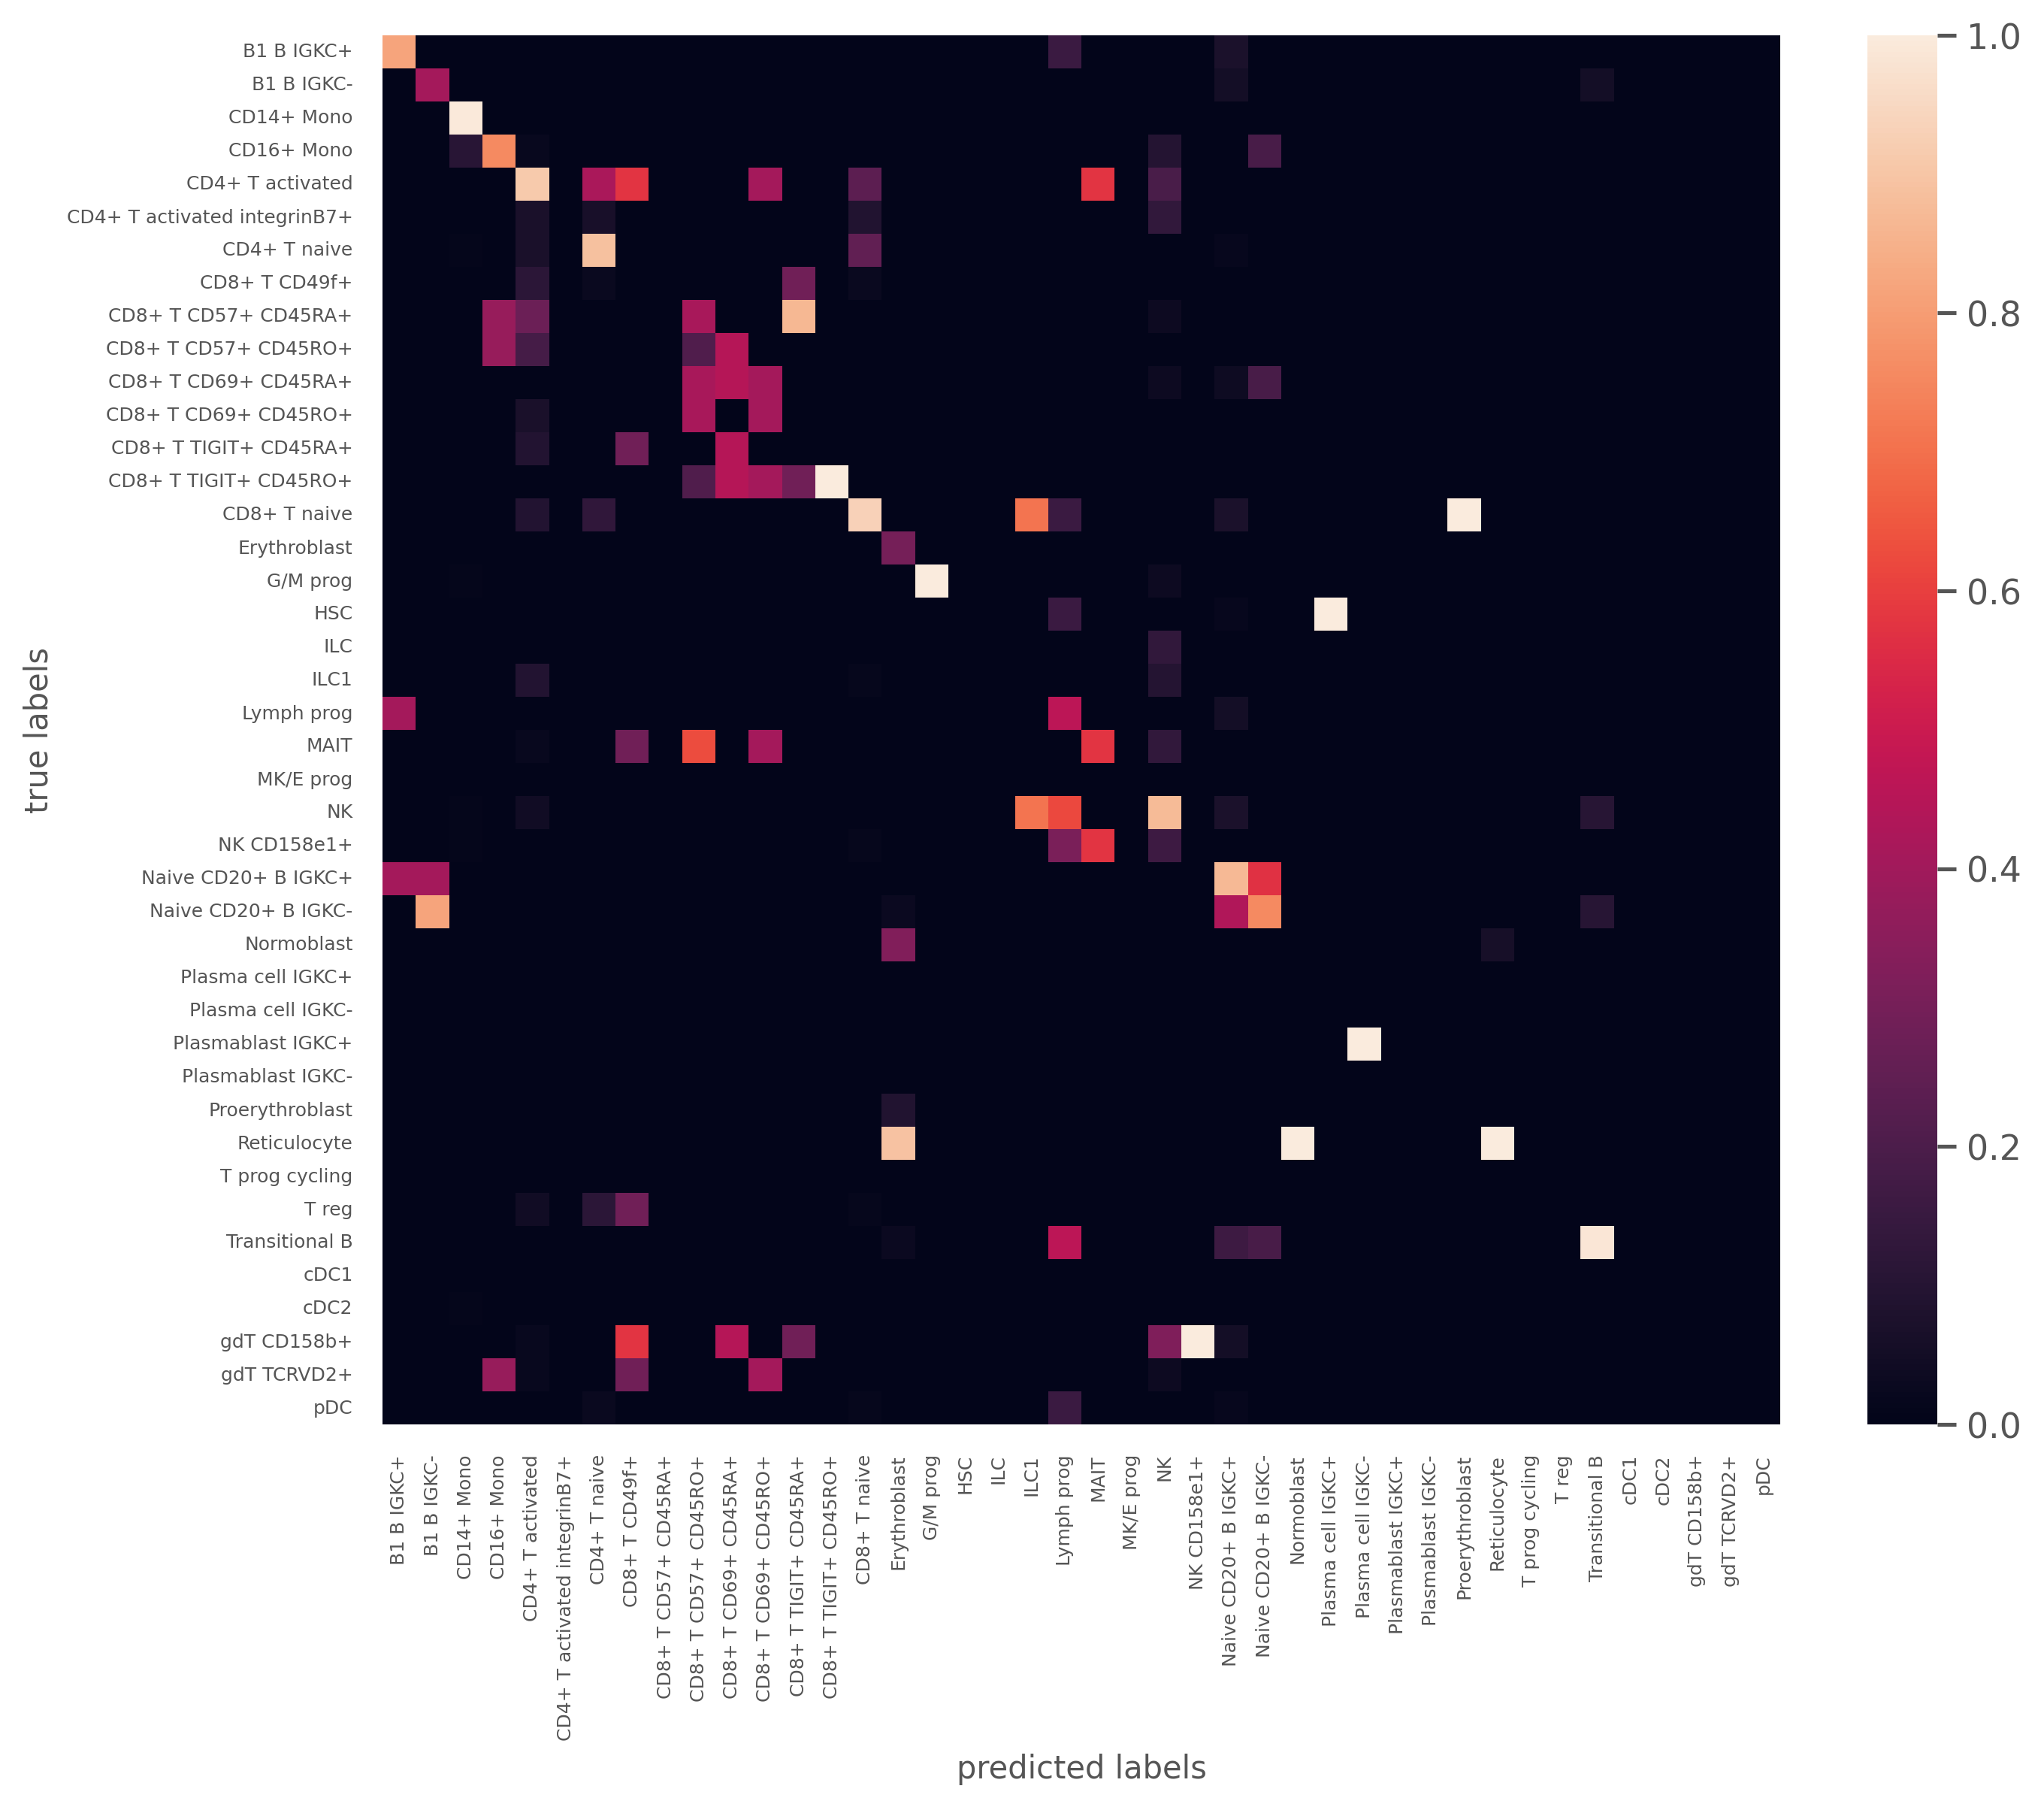

In [89]:
plt.figure(figsize=(10, 8))

confusion_matrix = sklearn.metrics.confusion_matrix(query.obs["cell_type"], predicted_labels, labels=sorted(np.unique(sorted(np.unique(adata.obs["cell_type"])))))
norm_confusion_matrix = normalize(confusion_matrix, axis=0)

data_norm_confusion_matrix = []
for true_label_index, true_label in enumerate(sorted(np.unique(adata.obs["cell_type"]))):
    for pred_label_index, pred_label in enumerate(sorted(np.unique(adata.obs["cell_type"]))):
        data_norm_confusion_matrix.append([true_label, pred_label, norm_confusion_matrix[true_label_index, pred_label_index]])
df = pd.DataFrame(columns=["true labels", "predicted labels", "prevalence"], data=data_norm_confusion_matrix)

ax = sns.heatmap(data=df['prevalence'].to_numpy().reshape(len(sorted(np.unique(adata.obs["cell_type"]))), len(sorted(np.unique(adata.obs["cell_type"])))), xticklabels=sorted(np.unique(adata.obs["cell_type"])), yticklabels=sorted(np.unique(adata.obs["cell_type"])), cbar=True)
ax.set_xlabel("predicted labels", fontsize=10)
ax.set_ylabel("true labels", fontsize=10)
ax.tick_params(axis='x', labelsize=6)
ax.tick_params(axis='y', labelsize=6)
plt.show()